The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Gráfico salvo como 'Images/WindSpeed.eps'


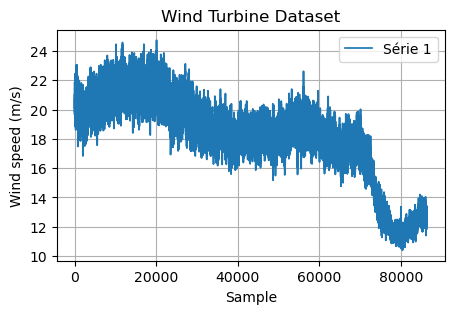

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy import signal
from scipy.integrate import solve_ivp
from scipy.signal import cont2discrete, tf2ss
import math
from _GraphUtils import *
import control as ct
from numba import njit

def Cp_calc(LAMBDA=0, PHI=0):
    #PHI = PHI*180/np.pi
    #path = r'TSRxCPxPSI.csv'
    path = r'Cp.csv'
    df = pd.read_csv(path)
    #angles = np.arange(-5,6,1)
    angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

def Cq_calc(LAMBDA=0, PHI=0):
    #PHI = PHI*180/np.pi
    path = r'Cq.csv'
    df = pd.read_csv(path)
    angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]


path = r'params2.csv'
params = pd.read_csv(path)
params = dict(zip(params['Parameter'], params['Value']))

path2 = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path2)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4*1.5
#v = np.array([10 for i in range(len(v))])

PlotSeries(y_arrays=[v[:]],w=5,h=3,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False, file_name=r'Images/WindSpeed.eps',save=True,lw=1.25)

In [2]:
class AerodynamicModel:
    def __init__(self, **params):

        self.PI =params['PI']
        self.R =params['R']
        self.RHO =params['RHO']
        self.τ_r = np.array([])
    
    def calculte_τr(self, ω_r, v, φ_m=0):
        #print(ω_r, self.R, v)
        λ = ω_r*self.R/v
        C_q = Cq_calc(λ, φ_m)
        #τ_r = self.RHO*self.Area*C_p*(v**3)/(2*ω_r)
        τ_r = self.RHO*self.PI*(self.R**3)*C_q*(v**2)/(2)
        self.τ_r = np.append(self.τ_r, τ_r)
        return τ_r


In [3]:
class PowerController:
    def __init__(self, **params):

        self.Area =params['Area']
        self.k_i =params['k_i']
        self.k_p =params['k_p']
        self.N_g =params['N_g']
        self.PI =params['PI']
        self.P_r =params['P_r']
        self.R =params['R']
        self.RHO =params['RHO']
        #self.T_s = params['T_s']
        self.T_s = 1        
        self.λ_opt =params['LAMBDA_opt']
        self.η_gc = params['ETA_gc']
        self.ω_nom = params['OMEGA_nom']
        self.ω_var = params['OMEGA_var']
        self.τ_gr = np.array([])
        self.ε = np.array([])
        self.φ_ref = np.array([])
        self.mode = 'mode1'
        self.mode_hist = np.array([])

    def calculte_τgr1(self, ω_g, u_k=0):

        ε = ω_g - self.ω_nom
        λ = self.λ_opt + u_k
        C_p = Cp_calc(λ,0)
        K_opt = self.RHO*self.Area*(self.R**3)*C_p/(2*(λ**3)*self.N_g)
        τ_gr = K_opt*((ω_g/self.N_g)**2)
        τ_gr = τ_gr.item(0)

        φ_ref = 0
        self.τ_gr = np.append(self.τ_gr, τ_gr)
        self.φ_ref = np.append(self.φ_ref, φ_ref)
        self.ε = np.append(self.ε, ε)
        self.mode_hist = np.append(self.mode_hist, 1)
        return τ_gr, φ_ref
    
    def calculte_τgr2(self, ω_g, u_k=0):

        ε = ω_g - self.ω_nom
        τ_gr = self.P_r/(self.η_gc*ω_g)
        τ_gr = τ_gr.item(0)
        φ_ref = self.φ_ref[-1] + self.k_p*ε + (self.k_i * self.T_s - self.k_p)*(self.ε[-1])
        self.τ_gr = np.append(self.τ_gr, τ_gr)
        self.φ_ref = np.append(self.φ_ref, φ_ref)
        self.ε = np.append(self.ε, ε)
        self.mode_hist = np.append(self.mode_hist, 2)
        return τ_gr, φ_ref


In [4]:
class GeneratorTorqueConverter:
    def __init__(self, **params):

        self.α_gc = params['ALPHA_gc']
        self.η_gc = params['ETA_gc']
        self.ω_nom = params['OMEGA_nom']
        self.ω_var = params['OMEGA_var']

        #self.T_s = params['T_s']
        self.T_s = 1
        self.X  = np.array([[0]])
        self.Y  = np.array([[0.0]])
        self.U  = np.array([[0]])
        self.X_hist = np.empty((0, 1))
        self.Y_hist = np.empty((0, 1))
        self.U_hist = np.empty((0, 1))
        self.P_g = np.array([])

        num = [self.α_gc]
        den = [1, self.α_gc]

        gtc_tf = ct.tf(num, den)
        gtc_c = gtc_tf.to_ss()
        gtc_d = ct.c2d(gtc_c, self.T_s, method='zoh')

        self.A, self.B, self.C, self.D = gtc_d.A, gtc_d.B, gtc_d.C, gtc_d.D
    
    def calculate_τg(self,ω_g,τ_gr):

        self.U = np.array([[τ_gr]])
        self.X_hist = np.append(self.X_hist, self.X, axis=0)
        self.U_hist = np.append(self.U_hist, self.U, axis=0)
        X_k, U_k = self.X.reshape(-1,1), self.U.reshape(-1,1)
        self.X = (self.A @ X_k + self.B @ U_k).reshape(1,1)
        self.Y = (self.C @ X_k + self.D @ U_k).reshape(1,1)
        P_g = self.η_gc*ω_g*self.Y.item(0)
        self.Y_hist = np.append(self.Y_hist, self.Y, axis=0)
        self.P_g = np.append(self.P_g, P_g)
        return self.Y.item(0), self.P_g


In [5]:
class PitchAngleController:
    def __init__(self, **params):

        self.ω_n = params['OMEGA_n']
        self.ζ = params['ZETA']
        #self.T_s = params['T_s']
        self.T_s = 1
        self.X  = np.array([[0, 0]])
        self.Y  = np.array([[0.0]])
        self.U  = np.array([[0.1]])
        self.X_hist = np.empty((0, 2))
        self.Y_hist = np.empty((0, 1))
        self.U_hist = np.empty((0, 1))
        self.φ_m = np.array([0])


        num = [self.ω_n**2]
        den = [1, 2*self.ω_n*self.ζ, self.ω_n**2]

        pac_tf = ct.tf(num, den)
        pac_c = pac_tf.to_ss()
        pac_d = ct.c2d(pac_c, self.T_s, method='zoh')

        self.A, self.B, self.C, self.D = pac_d.A, pac_d.B, pac_d.C, pac_d.D
    
    def calculate_φm(self, φ_ref):

        self.U = np.array([[φ_ref]])
        self.X_hist = np.append(self.X_hist, self.X, axis=0)
        self.U_hist = np.append(self.U_hist, self.U, axis=0)
        X_k, U_k = self.X.reshape(-1,1), self.U.reshape(-1,1)
        self.X = (self.A @ X_k + self.B @ U_k).reshape(1,2)
        self.Y = (self.C @ X_k + self.D @ U_k).reshape(1,1)
        self.Y_hist = np.append(self.Y_hist, self.Y, axis=0)
        self.φ_m = np.append(self.φ_m, self.Y)
        return self.Y.item(0)


In [6]:
class HAWT:
    def __init__(self, **params):

        self.Area =params['Area']
        self.α_gc = params['ALPHA_gc']
        self.B_dt =params['B_dt']
        self.B_r =params['B_r']
        self.B_g =params['B_g']
        self.CP_max =params['CP_max']
        self.ETA_dt =params['ETA_dt']
        self.ETA_gc =params['ETA_gc']
        self.J_r =params['J_r']
        self.J_g =params['J_g']
        self.K_dt =params['K_dt']
        self.k_i =params['k_i']
        self.k_p =params['k_p']
        self.λ_opt =params['LAMBDA_opt']
        self.N_g =params['N_g']
        self.OMEGA_n =params['OMEGA_n']
        self.OMEGA_nom =params['OMEGA_nom']
        self.OMEGA_var =params['OMEGA_var']
        self.PHI_opt = params['PHI_opt']
        self.P_r =params['P_r']
        self.PI =params['PI']
        self.R =params['R']
        self.RHO =params['RHO']
        #self.T_s = params['T_s']
        self.T_s = 1        
        self.Ad = None
        self.Bd = None
        self.U = None
        self.X  = np.array([[0.1,0.1*self.N_g,0]])
        self.U  = np.array([[0,0]])
        self.X_hist = np.empty((0, 3))
        self.U_hist = np.empty((0, 2))
        
        self.e = np.array([0])
        self.P_g = np.array([]) 
        self.K_mppt = np.array([])  
        self.P_d = np.array([]) 
        self.mode = np.array([])     
        self.ctrl_mode = 'mode1'
        self.φ_m = np.array([])
        self.dφ_m = np.array([0])
        self.φ_ref = np.array([]) 
        self.ω_r = np.array([])   
        self.ω_g = np.array([])
        self.θ_s = np.array([]) 
        self.τ_g = np.array([])
        self.τ_r = np.array([])  
        self.n = 0


        A11 = -(self.B_dt+self.B_r)/self.J_r
        A12 = self.B_dt/(self.N_g*self.J_r)
        A13 = -self.K_dt/self.J_r
        A21 = (self.B_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A22 = -(((self.B_dt*self.ETA_dt)/(self.N_g**2))+self.B_g)*(1/self.J_g)
        A23 = (self.K_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A32 = -1/self.N_g
        B11 = 1/self.J_r
        B22 = -1/self.J_g
        dt = self.T_s
        
        A = np.array([[A11, A12, A13],
                      [A21, A22, A23],
                      [  1, A32,   0]])
        
        B = np.array([[B11,   0],
                      [  0, B22],
                      [  0,   0]])

        n_states = A.shape[0]
        n_inputs = B.shape[1]
        C = np.eye(n_states) 
        D = np.zeros((n_states, n_inputs))

        sys_c = ct.ss(A, B, C, D)
        #sys_discrete = signal.cont2discrete(sys_continuous, dt=self.T_s, method='backward_diff')
        sys_d = ct.c2d(sys_c, dt, method='zoh')
        self.Ad = sys_d.A 
        self.Bd = sys_d.B 
    
    """ def compute_input(self,v):
        X = self.X.reshape(-1,1)
        ω_r, ω_g, θ_s = X[0],X[1],X[2]
        τ_r = self.calculte_τr(ω_r,φ_m=0,v=v)
        τ_g = self.calculte_τg(ω_g)
        self.U = np.array([[τ_r,τ_g]]) """

    def simulate(self,τ_r, τ_g):

        self.U = np.array([[τ_r,τ_g]])
        self.X_hist = np.append(self.X_hist, self.X, axis=0)
        self.U_hist = np.append(self.U_hist, self.U, axis=0)
        X_k, U_k = self.X.reshape(-1,1), self.U.reshape(-1,1)
        self.X = (self.Ad @ X_k + self.Bd @ U_k).reshape(1,3)
        X = self.X.flatten()
        return X[0],X[1],X[2]
    
    def get_state(self):
        return self.X.flatten()
    
    def set_input(self,τ_r, τ_g):
        self.U = np.array([[τ_r,τ_g]])


In [7]:
""" hawt = HAWT(**params)
gtc = GeneratorTorqueConverter(**params)
pac = PitchAngleController(**params)
pwc = PowerController(**params)
adm = AerodynamicModel(**params) """

' hawt = HAWT(**params)\ngtc = GeneratorTorqueConverter(**params)\npac = PitchAngleController(**params)\npwc = PowerController(**params)\nadm = AerodynamicModel(**params) '

In [8]:
""" ω_r, ω_g, θ_s = hawt.get_state()

if pwc.mode == 'mode1':
    τ_gr, φ_ref = pwc.calculte_τgr1(ω_g,u_k=0) 
if pwc.mode == 'mode2':
    τ_gr, φ_ref = pwc.calculte_τgr2(ω_g,u_k=0) 

τ_g, P_g = gtc.calculate_τg(ω_g,τ_gr)

φ_m = pac.calculate_φm(φ_ref)
τ_r = adm.calculte_τr(ω_r,v[0],φ_m)
X = hawt.simulate(τ_r, τ_g)

if pwc.mode == 'mode1':
    if P_g >= pwc.P_r or ω_g >= pwc.ω_nom:
        pwc.mode = 'mode2'
if pwc.mode == 'mode2':
    if ω_g < pwc.ω_nom - pwc.ω_var:
        pwc.mode = 'mode1'

vrs = [r'φ_m',r'τ_r',r'τ_gr',r'τ_g',r'φ_ref']
prs = [φ_m,τ_r,τ_gr,τ_g,φ_ref]
for vr,p in zip(vrs,prs):
    print(vr,p)
 """

" ω_r, ω_g, θ_s = hawt.get_state()\n\nif pwc.mode == 'mode1':\n    τ_gr, φ_ref = pwc.calculte_τgr1(ω_g,u_k=0) \nif pwc.mode == 'mode2':\n    τ_gr, φ_ref = pwc.calculte_τgr2(ω_g,u_k=0) \n\nτ_g, P_g = gtc.calculate_τg(ω_g,τ_gr)\n\nφ_m = pac.calculate_φm(φ_ref)\nτ_r = adm.calculte_τr(ω_r,v[0],φ_m)\nX = hawt.simulate(τ_r, τ_g)\n\nif pwc.mode == 'mode1':\n    if P_g >= pwc.P_r or ω_g >= pwc.ω_nom:\n        pwc.mode = 'mode2'\nif pwc.mode == 'mode2':\n    if ω_g < pwc.ω_nom - pwc.ω_var:\n        pwc.mode = 'mode1'\n\nvrs = [r'φ_m',r'τ_r',r'τ_gr',r'τ_g',r'φ_ref']\nprs = [φ_m,τ_r,τ_gr,τ_g,φ_ref]\nfor vr,p in zip(vrs,prs):\n    print(vr,p)\n "

In [9]:
hawt = HAWT(**params)
gtc = GeneratorTorqueConverter(**params)
pac = PitchAngleController(**params)
pwc = PowerController(**params)
adm = AerodynamicModel(**params)

for i in range(len(v)):

    ω_r, ω_g, θ_s = hawt.get_state()

    if pwc.mode == 'mode1':
        τ_gr, φ_ref = pwc.calculte_τgr1(ω_g,u_k=0) 
    if pwc.mode == 'mode2':
        τ_gr, φ_ref = pwc.calculte_τgr2(ω_g,u_k=0) 

    τ_g, P_g = gtc.calculate_τg(ω_g,τ_gr)

    φ_m = pac.calculate_φm(φ_ref)
    τ_r = adm.calculte_τr(ω_r,v[i],φ_m)
    X = hawt.simulate(τ_r, τ_g)

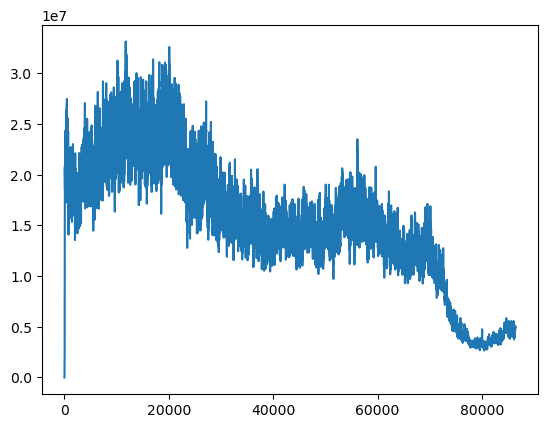

In [10]:
plt.plot(gtc.P_g)